In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import corner

import funcs

### Problem 1

Last data set from PS2: corner plot.

In [2]:
# 11th data set from pset 2
with open("pset2_data.pkl", "rb") as handle:
    data = pkl.load(handle).T # check out that pesky little `.T`
time, sigmas, signal = data[0], data[1], data[-1]

In [3]:
# 1D Gaussian
def Gaussian(x, mu, sigma):
    exp = -0.5 * ((x-mu)/sigma)**2
    coeff = 1/(sigma*np.sqrt(2*np.pi))
    return coeff*np.e**exp

In [4]:
# log likelihood given a data set and parameters
def lnL(pars, time, signal, sigmas):
    fit = funcs.func_2sigs(time, *pars, T0=100)
    loglike = funcs.get_loglike(signal, fit, sigmas)
    return loglike

In [5]:
# parameters which maximize the likelihood for this signal with T0 = 100
thissignal = funcs.Signal(time, signal, sigmas)
thissignal.find_second_period()
print(thissignal.second_T)

theta, cov = thissignal.fit_2sigs(T=thissignal.second_T)
B_known, A1_known, A2_known, A3_known, A4_known = theta
print(theta)

259.5024211399737
[0.08129183 1.96926322 2.28682714 0.63378347 0.52646242]


In [9]:
# priors
def lnprior_T(T, minT=0, maxT=1024):
    if T < minT:
        return -np.inf
    elif T > maxT:
        return -np.inf
    else:
        return 1

def lnprior_amp(amp, mu=0, sigma=1):
    return Gaussian(amp, mu, sigma)

def lnprior_dc(dc, mu=0, sigma=0.5):
    return Gaussian(dc, mu, sigma)

def lnprior(pars):
    T, B, A1, A2, A3, A4 = pars
    lnp = 0
    lnp += lnprior_T(T)
    lnp += lnprior_dc(B)
    for amp in [A1, A2, A3, A4]:
        lnp += lnprior_amp(amp)
    return lnp

In [10]:
def MCMC(n, init_pars, time, signal, sigmas):
    def sample_dist(pars):
        return lnprior(pars) + lnL(pars, time, signal, sigmas)
    def prop_dist(pars):
        T, B, A1, A2, A3, A4 = pars
        dist_T = np.random.normal(loc=T, scale=0.9)
        dist_B = np.random.normal(loc=B, scale=0.08)
        dist_A1 = np.random.normal(loc=A1, scale=0.07)
        dist_A2 = np.random.normal(loc=A2, scale=0.07)
        dist_A3 = np.random.normal(loc=A3, scale=0.07)
        dist_A4 = np.random.normal(loc=A4, scale=0.07)
        dist = np.array([dist_T, dist_B, dist_A1, dist_A2, dist_A3, dist_A4])
        return dist
    states = funcs.mh_mcmc(n, init_pars=init_pars, lnpost=sample_dist, proposal=prop_dist)
    return states

In [11]:
init_pars = [259.5, 0, 1, 1, 0, 0]

In [12]:
n = 500000
samples = MCMC(n, init_pars, time, signal, sigmas)

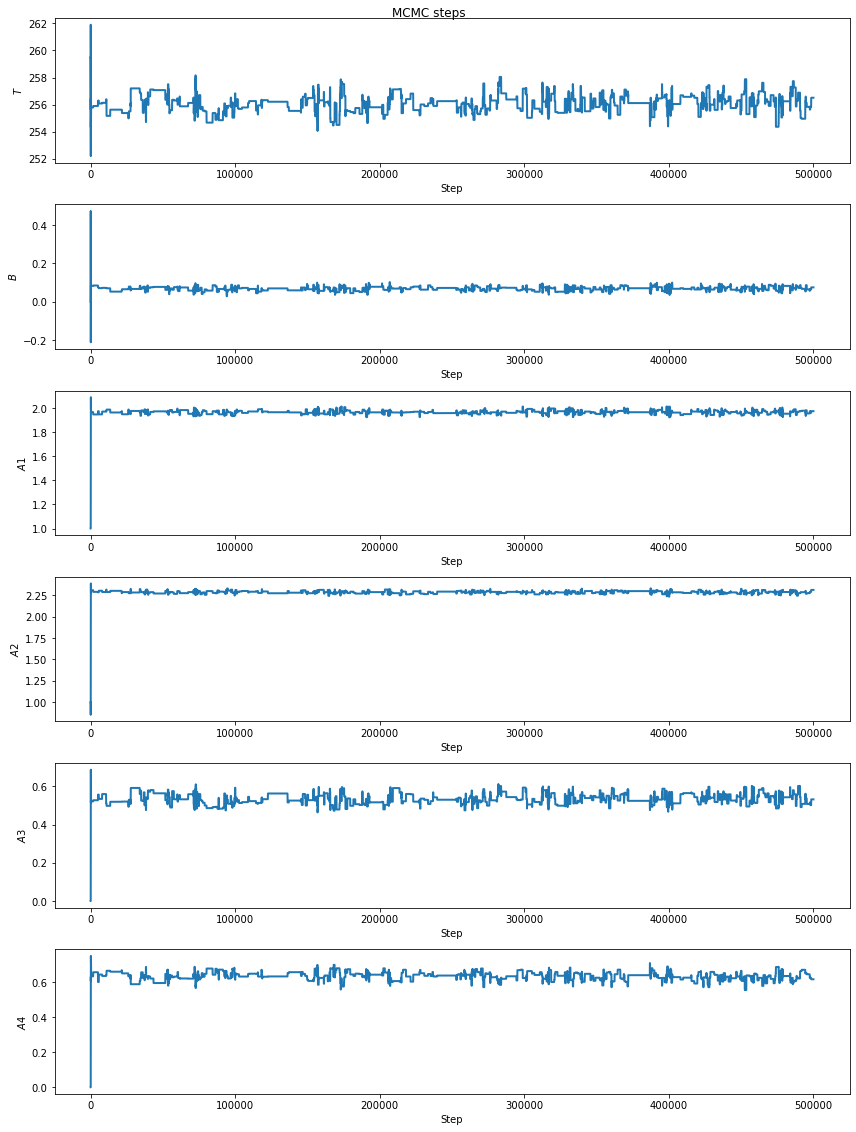

In [13]:
fig, axs = plt.subplots(6, 1, figsize=(12,16))

pars_labels = ['$T$', '$B$', '$A1$', '$A2$', '$A3$', '$A4$']

for i, ax in enumerate(axs):
    ax.plot(samples[:,i], lw=2)

    ax.set_xlabel('Step')
    ax.set_ylabel(pars_labels[i])
    # ax.set_xscale('log')

fig.suptitle('MCMC steps')
fig.tight_layout()

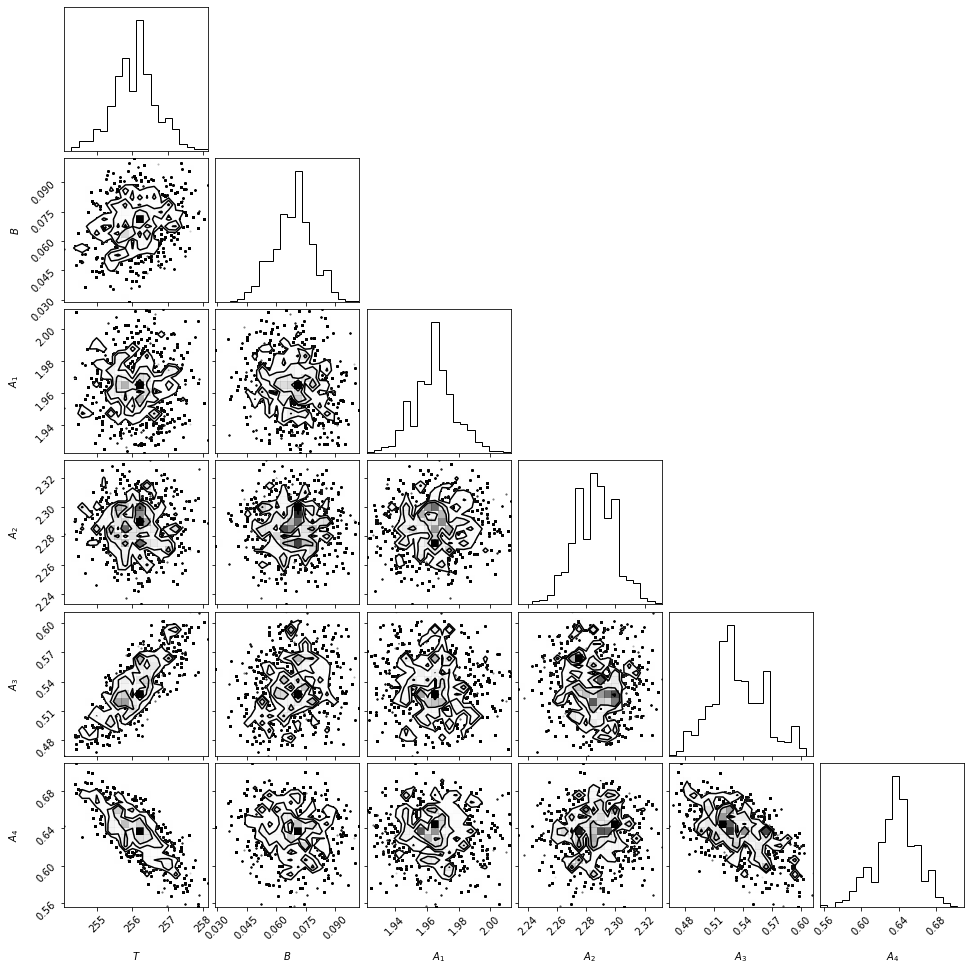

In [14]:
# corner plot of sample distribution
figure = corner.corner(samples[500:],
                        labels=['$T$', '$B$', '$A_1$', '$A_2$', '$A_3$', '$A_4$'])

In [15]:
# plot a sampling of 16 independent samples from the posterior in the space of the data, on the data
def draw_sample(param_dists):
    sample = np.array([np.random.choice(dist) for dist in param_dists])
    return sample

In [17]:
ndraws = 16
draws = np.array([draw_sample(samples[500:].T) for i in range(ndraws)])

In [18]:
# compute the fits using our 16 parameter sets
fits = np.empty((ndraws, len(signal)))
for i, draw in enumerate(draws):
    fits[i] = funcs.func_2sigs(time, *draw, T0=100)

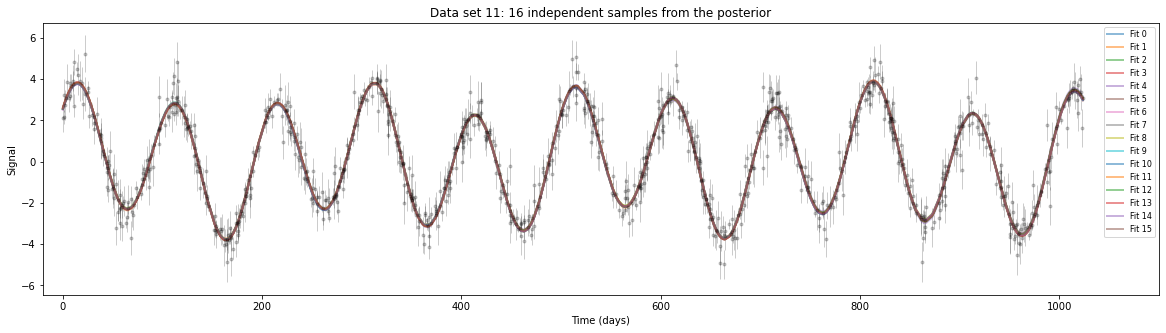

In [30]:
fig, ax = plt.subplots(figsize=(20, 5))

ax.errorbar(time, signal, yerr=sigmas, ls='None', lw=1, color='k', marker='.', alpha=0.2)
for i, fit in enumerate(fits):
    ax.plot(time, fit, lw=2, alpha=0.5, label=f'Fit {i}')
ax.set_xlim((-20,1100))
ax.set_xlabel('Time (days)')
ax.set_ylabel('Signal')
ax.set_title(f'Data set 11: 16 independent samples from the posterior')
ax.legend(prop={'size':8})

### Problem 2

Same data set: residuals plotted and folded at the putative best-fit second period.

In [31]:
data = {
    'time' : data[0],
    'signal' : data[-1],
    'sigmas' : data[1]
}
T = 100

In [32]:
# linear least-squares fit
theta, cov = thissignal.fit_1sig(T)
B, A1, A2 = theta   # unpack best-fit params
A = np.sqrt(A1**2 + A2**2)  # overall amplitude
B_var, A1_var, A2_var = np.diag(cov)    # get variances
A_sigma = np.sqrt(A1_var+A2_var)        # overall error
snr = A/A_sigma                         # ~ signal-to-noise
print(f"Data set: A = {A:.3f}, A_sigma = {A_sigma:.3f} ==> SNR = {snr:.2f}")

# plug best-fit params back into the signal equation to get the best fit
fit = funcs.func_1sig(time, T, *theta)

# compute chi-squared to assess goodness of fit
loglike = funcs.get_loglike(signal, fit, sigmas)

Data set: A = 3.099, A_sigma = 0.020 ==> SNR = 156.06


In [33]:
# residuals
res = signal - fit

In [34]:
# best-fit second period 
T1 = thissignal.second_T

Text(0.5, 0.98, '11th data set from pset2')

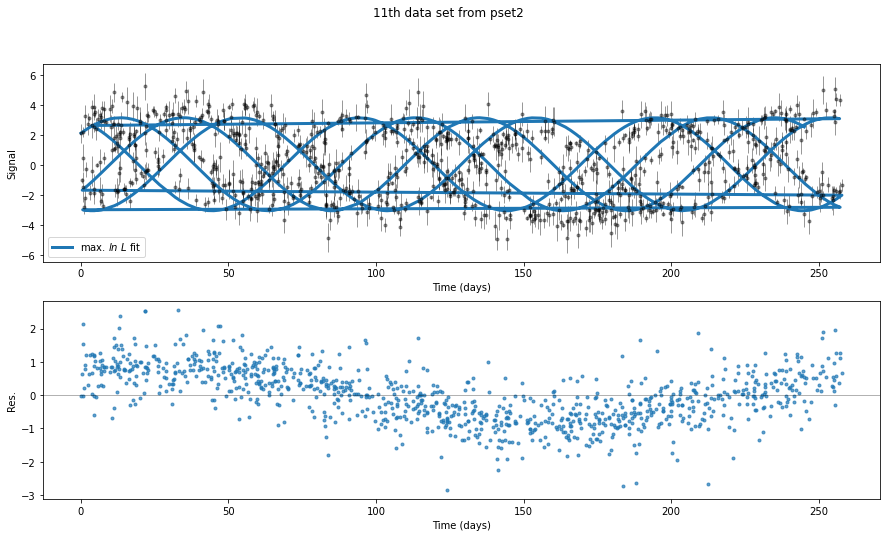

In [35]:
# plot data and fitted 100-day signal, and residuals
fig, axs = plt.subplots(2, 1, figsize=(15, 8))

axs[0].errorbar(time%T1, data['signal'], yerr=sigmas, lw=1, ls='None', color='k', marker='.', alpha=0.4)
axs[0].plot(time%T1, fit, lw=3, label=f'max. $ln\ L$ fit')
axs[0].set_ylabel('Signal')
axs[0].legend()

axs[1].plot(time%T1, res, ls='None', marker='.', alpha=0.7)
axs[1].set_ylabel('Res.')
axs[1].axhline(0, lw=1, color='k', alpha=0.3)

for ax in axs:
    ax.set_xlabel('Time (days)')

fig.suptitle(f'11th data set from pset2')

I'd argue that the model is believable because we can see the second signal captured visually in the residual plot. The fit in the top plot only includes the 100-day signal, so since we know there is a second signal, we DO expect there to be a single period signal if we fold at the putative best-fit second signal. Despite noise this single period is pretty clear in the residual plot.

### Problem 3

K-fold cross-validation for problem #2 of PS2.

In [39]:
K = 8
T = 100

In [40]:
# fit one signal to all but one eighth of each data set, for all eight held-out sets
def kfold_crossval_1sig(time, signal, sigmas, T0=100, K=8):
    cut_size = int(len(time)/K)
    times = np.empty((K, len(time)-cut_size))
    fits = np.empty((K, len(time)))
    loglikes = np.zeros(K)
    for i in range(K):
        time_K = np.concatenate((time[:i*cut_size], time[(i+1)*cut_size:]))
        times[i] = time_K
        signal_K = np.concatenate((signal[:i*cut_size], signal[(i+1)*cut_size:]))
        sigmas_K = np.concatenate((sigmas[:i*cut_size], sigmas[(i+1)*cut_size:]))
        Signal = funcs.Signal(time_K, signal_K, sigmas_K)
        # fit one signal with a period of 100 days
        theta, cov = Signal.fit_1sig(T0)
        # fit these parameters to all of the points
        fit_K = funcs.func_1sig(time, T0, *theta)
        fits[i] = fit_K
        loglikes[i] = funcs.get_loglike(signal, fit_K, sigmas)
    return times, fits, loglikes

In [41]:
# fit two signals to all but one eighth of each data set, for all eight held-out sets
def kfold_crossval_2sigs(time, signal, sigmas, T1, T0=100, K=8):
    cut_size = int(len(time)/K)
    times = np.empty((K, len(time)-cut_size))
    fits = np.empty((K, len(time)))
    loglikes = np.zeros(K)
    for i in range(K):
        time_K = np.concatenate((time[:i*cut_size], time[(i+1)*cut_size:]))
        times[i] = time_K
        signal_K = np.concatenate((signal[:i*cut_size], signal[(i+1)*cut_size:]))
        sigmas_K = np.concatenate((sigmas[:i*cut_size], sigmas[(i+1)*cut_size:]))
        Signal = funcs.Signal(time_K, signal_K, sigmas_K)
        # fit one signal with a period of 100 days
        theta, cov = Signal.fit_2sigs(T=T1, T0=T0)
        # fit these parameters to all of the points
        fit_K = funcs.func_2sigs(time, T1, *theta, T0=T0)
        # fit_onlyK = funcs.func_2sigs(time_K, T1, *theta, T0=T)
        fits[i] = fit_K
        loglikes[i] = funcs.get_loglike(signal, fit_K, sigmas)
    return times, fits, loglikes

In [88]:
def plot_kfold_fits(time, signal, sigmas, fits, title=None, K=8):
    fig, axs = plt.subplots(2, 1, figsize=(18,5))

    axs[0].errorbar(time, signal, yerr=sigmas, lw=1, ls='None', color='k', marker='.', alpha=0.2)
    for i in range(K):
        axs[0].plot(time, fits[i], lw=2, alpha=0.5, label=f'K={i}')
        axs[1].plot(time, signal-fits[i], ls='None', alpha=0.5, marker='.', label=f'K={i}')

    axs[1].axhline(0, color='k', alpha=0.3, lw=1)
    for ax in axs:
        ax.set_xlim((time[0]-20, time[-1]+80))
        ax.legend()
    fig.suptitle(title)
    fig.tight_layout()
    plt.show()

In [89]:
times1, fits1, loglikes1 = kfold_crossval_1sig(time, signal, sigmas, K=8)
times2, fits2, loglikes2 = kfold_crossval_2sigs(time, signal, sigmas, T1=T1, K=8)

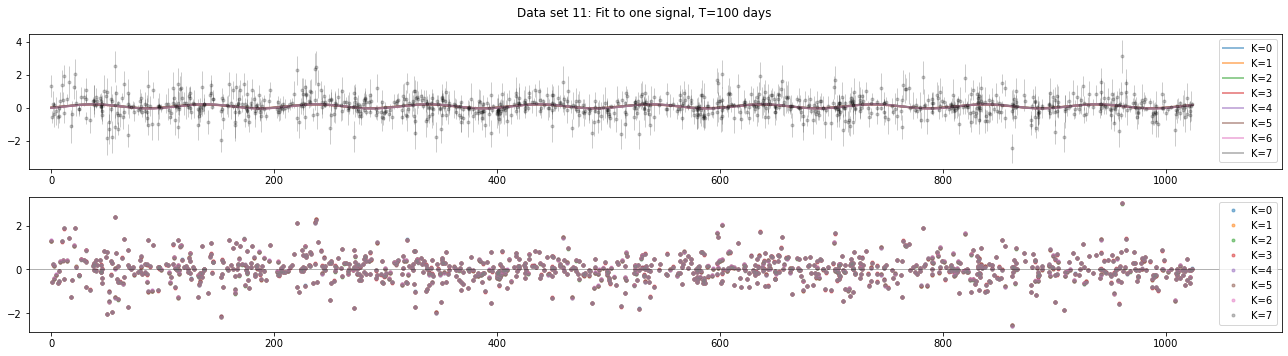

In [90]:
plot_kfold_fits(time, signal, sigmas, fits1, title='Data set 11: Fit to one signal, T=100 days')

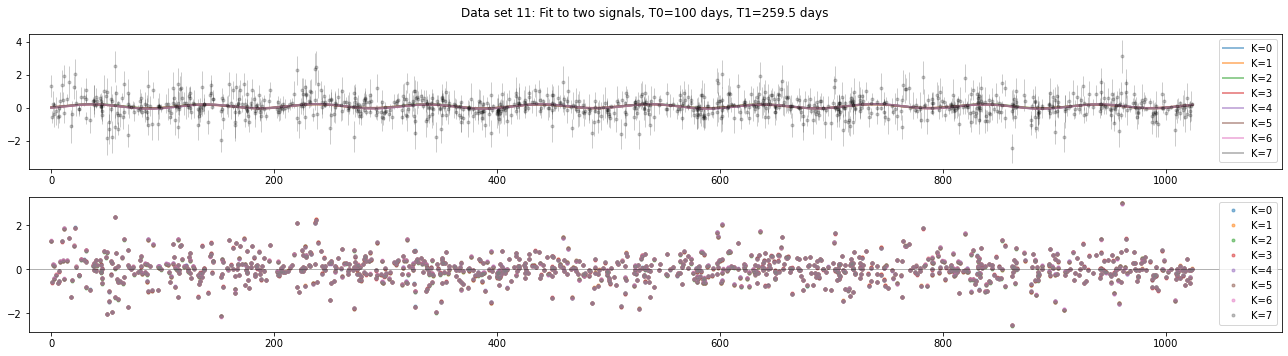

In [91]:
plot_kfold_fits(time, signal, sigmas, fits2, title=f'Data set 11: Fit to two signals, T0=100 days, T1={T1:.1f} days')

#### AIC and BIC

In [92]:
def AIC(k, loglike):    # where k is the number of parameters in the model
    return 2*k - 2*loglike

In [93]:
def BIC(k, loglike, N):
    return k * np.log(N) - 2*loglike

In [94]:
aic1 = AIC(4, loglikes1)
aic2 = AIC(7, loglikes2)
print(aic1, aic2)

[1003.4185546  1003.36147687 1003.76843175 1005.29338159 1003.60556225
 1003.30605228 1003.86283088 1003.54117291] [1008.93499804 1009.33306643 1010.17609142 1010.74407332 1009.15865289
 1009.03366966 1009.4377422  1008.89884958]


In [95]:
bic1 = BIC(4, loglikes1, len(signal))
bic2 = BIC(7, loglikes2, len(signal))
print(bic1, bic2)

[1023.14444182 1023.08736409 1023.49431897 1025.01926881 1023.33144947
 1023.0319395  1023.5887181  1023.26706013] [1043.45530068 1043.85336907 1044.69639406 1045.26437596 1043.67895553
 1043.5539723  1043.95804484 1043.41915222]


In the case of data set 11, the two-signal model is the better fit according to both AIC and BIC.

Let's perform a similar k-fold cross-validation on the other 10 data sets:

In [101]:
def kfold_crossval(time, signal, sigmas, nset, T0=100):
    # k-fold cross-validation with 1-signal model
    times1, fits1, loglikes1 = kfold_crossval_1sig(time, signal, sigmas, T0=T0, K=8)

    # plot results
    plot_kfold_fits(time, signal, sigmas, fits1, title=f'Data set {nset}: Fit to one signal, T={T0} days')

    # second period
    thissignal = funcs.Signal(time, signal, sigmas)
    thissignal.find_second_period()
    T1 = thissignal.second_T
    
    # k-fold cross-validation with 2-signal model
    times2, fits2, loglikes2 = kfold_crossval_2sigs(time, signal, sigmas, T1=T1, T0=T0, K=8)

    # plot results
    plot_kfold_fits(time, signal, sigmas, fits1, title=f'Data set {nset}: Fit to two signals, T0={T0} days, T1={T1:.1f} days')

    # compute AIC and BIC
    aic1 = AIC(4, loglikes1)
    aic2 = AIC(7, loglikes2)

    bic1 = BIC(4, loglikes1, len(signal))
    bic2 = BIC(7, loglikes2, len(signal))

    print(f"Data set {nset} =====")
    print(f"AIC: \n 1 signal: {aic1} \n 2 signals: {aic2}")
    print(f"BIC: \n 1 signal: {bic1} \n 2 signals: {bic2}")

In [102]:
# 11th data set from pset 2
with open("pset2_data.pkl", "rb") as handle:
    data = pkl.load(handle).T # check out that pesky little `.T`
time, sigmas, signals = data[0], data[1], data[2:]

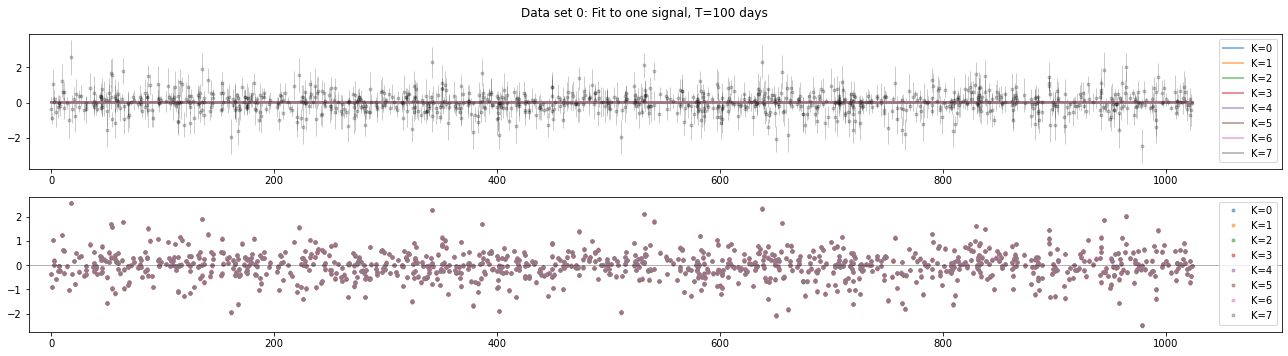

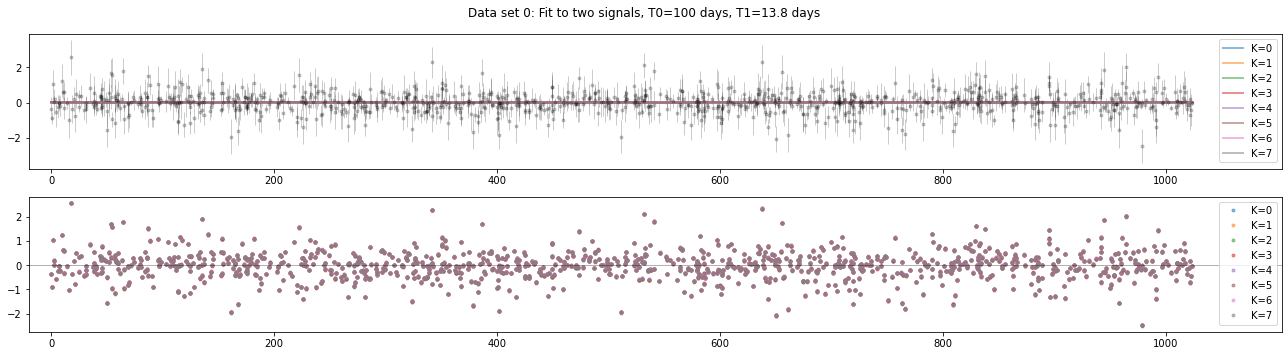

Data set 0 =====
AIC: 
 1 signal: [1015.56472599 1015.51776561 1016.26665044 1016.40096422 1015.79929815
 1015.48883695 1015.73041469 1015.99067304] 
 2 signals: [1016.19447366 1015.85734917 1017.42659988 1016.70557299 1016.14967553
 1015.89505665 1016.06193029 1016.41404225]
BIC: 
 1 signal: [1035.29061321 1035.24365283 1035.99253766 1036.12685144 1035.52518537
 1035.21472417 1035.45630191 1035.71656027] 
 2 signals: [1050.71477629 1050.37765181 1051.94690252 1051.22587563 1050.66997817
 1050.41535929 1050.58223293 1050.93434489]


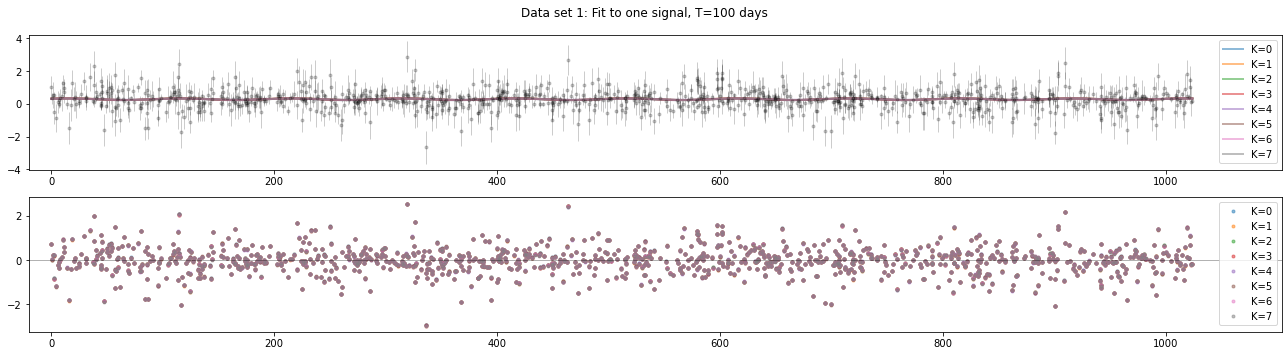

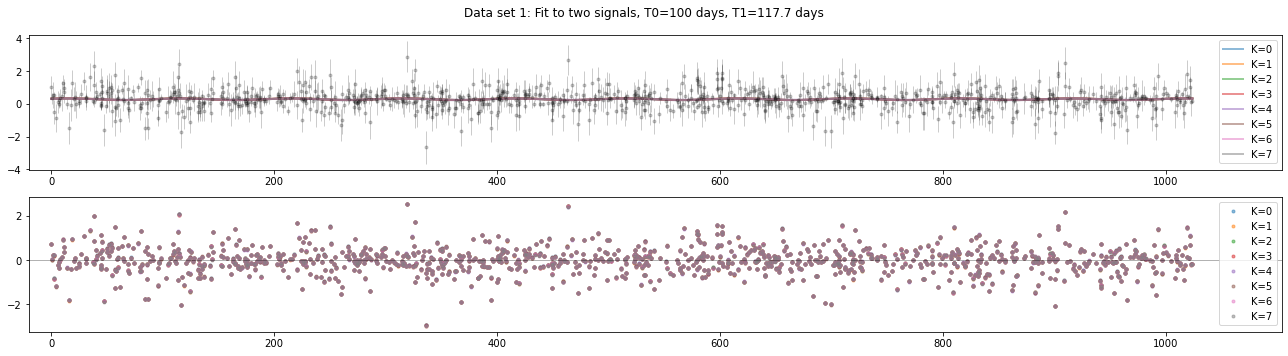

Data set 1 =====
AIC: 
 1 signal: [1021.80861937 1021.80772599 1021.6145244  1021.57985207 1022.17173467
 1022.22210672 1021.61406609 1022.06331506] 
 2 signals: [1018.54190141 1018.45586891 1018.68295478 1018.75865811 1018.7983809
 1018.72874586 1018.59990393 1018.75339762]
BIC: 
 1 signal: [1041.5345066  1041.53361322 1041.34041162 1041.30573929 1041.89762189
 1041.94799394 1041.33995332 1041.78920228] 
 2 signals: [1053.06220405 1052.97617155 1053.20325742 1053.27896075 1053.31868354
 1053.24904849 1053.12020657 1053.27370026]


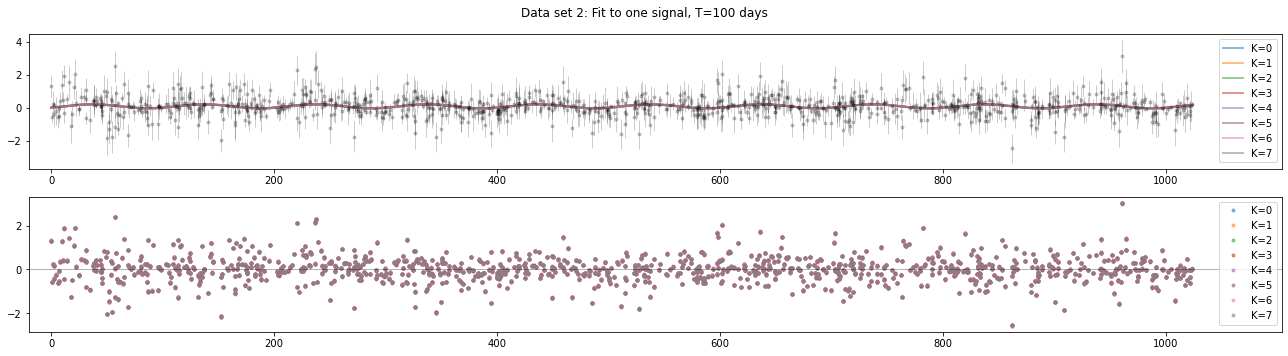

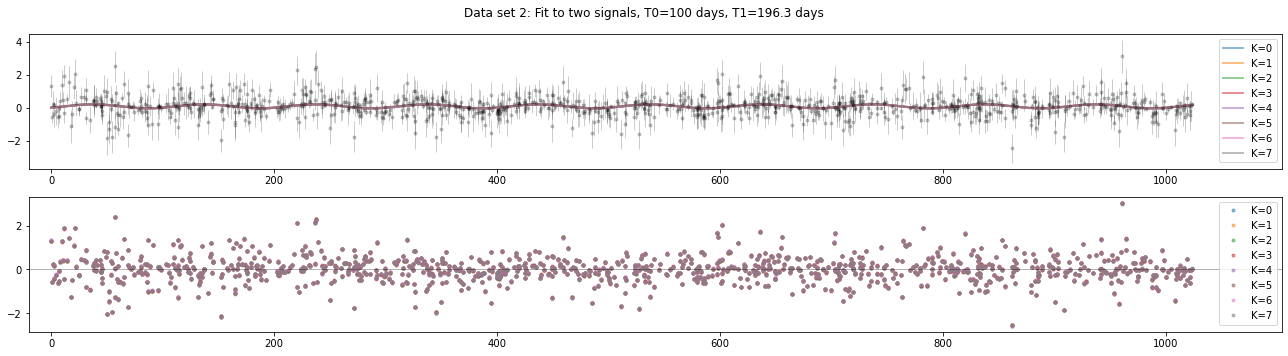

Data set 2 =====
AIC: 
 1 signal: [1003.4185546  1003.36147687 1003.76843175 1005.29338159 1003.60556225
 1003.30605228 1003.86283088 1003.54117291] 
 2 signals: [998.12440441 998.10867561 998.23923318 999.52767363 998.23051317
 998.08460617 998.33973475 998.76478796]
BIC: 
 1 signal: [1023.14444182 1023.08736409 1023.49431897 1025.01926881 1023.33144947
 1023.0319395  1023.5887181  1023.26706013] 
 2 signals: [1032.64470705 1032.62897825 1032.75953582 1034.04797627 1032.75081581
 1032.60490881 1032.86003739 1033.2850906 ]


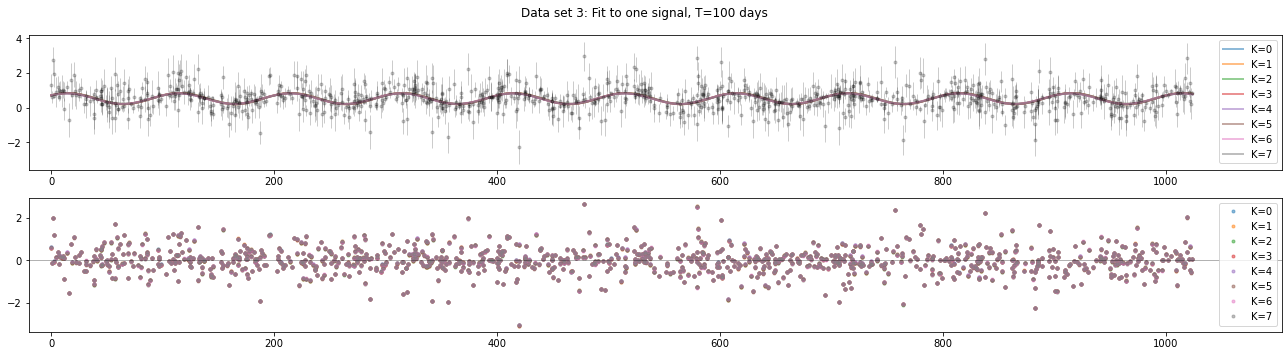

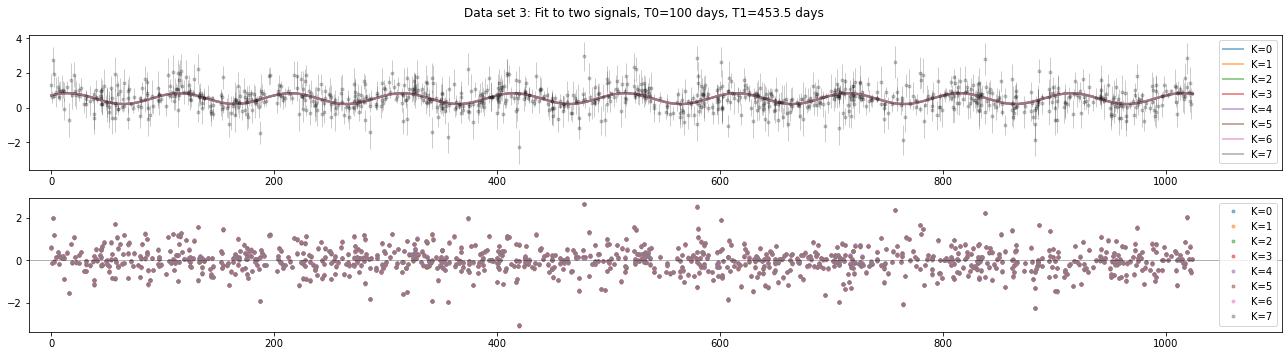

Data set 3 =====
AIC: 
 1 signal: [1048.19605574 1048.52216178 1048.82005953 1048.03602174 1048.15367063
 1049.83786022 1049.49667246 1048.40712954] 
 2 signals: [1044.27037091 1044.67626708 1044.63113736 1044.57480639 1044.27127297
 1046.62502995 1045.97026637 1044.33594328]
BIC: 
 1 signal: [1067.92194296 1068.248049   1068.54594675 1067.76190897 1067.87955786
 1069.56374744 1069.22255968 1068.13301677] 
 2 signals: [1078.79067355 1079.19656972 1079.15144    1079.09510903 1078.79157561
 1081.14533259 1080.49056901 1078.85624592]


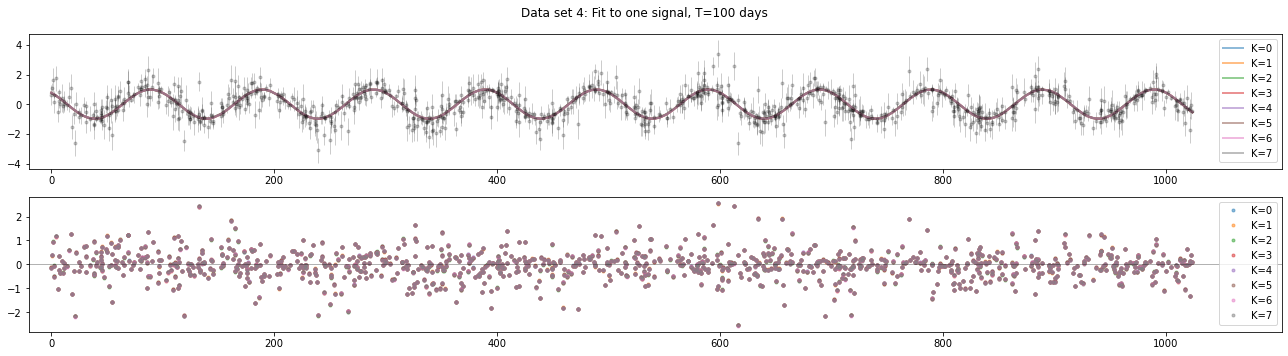

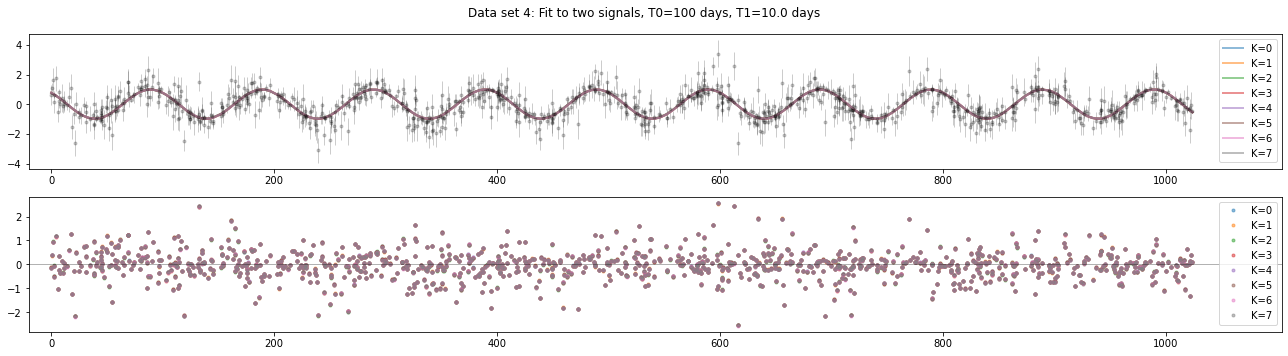

Data set 4 =====
AIC: 
 1 signal: [978.71555802 979.38097696 980.06130316 978.75153079 978.69622647
 978.62059053 978.84127399 978.65912136] 
 2 signals: [974.49840415 974.69031795 975.38322419 974.00419558 974.18657656
 974.6404648  974.22525861 974.17394986]
BIC: 
 1 signal: [998.44144524 999.10686419 999.78719038 998.47741801 998.42211369
 998.34647775 998.56716121 998.38500858] 
 2 signals: [1009.01870679 1009.21062059 1009.90352683 1008.52449822 1008.7068792
 1009.16076743 1008.74556125 1008.6942525 ]


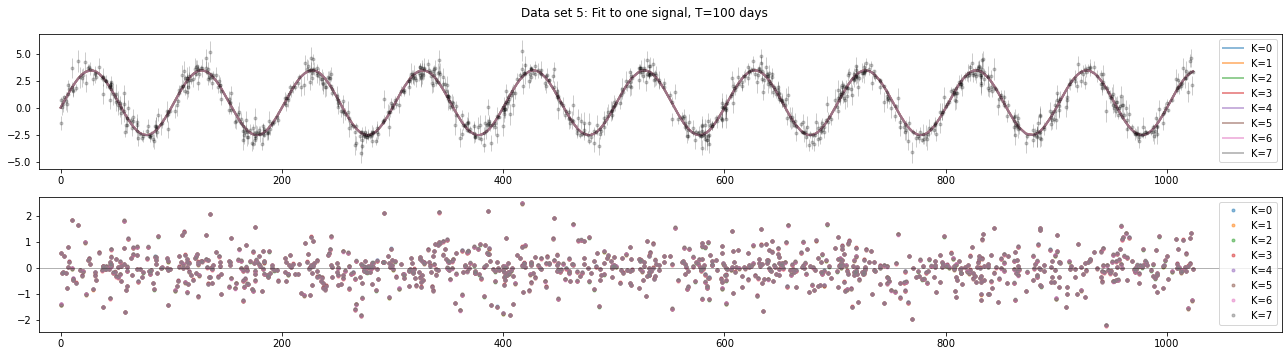

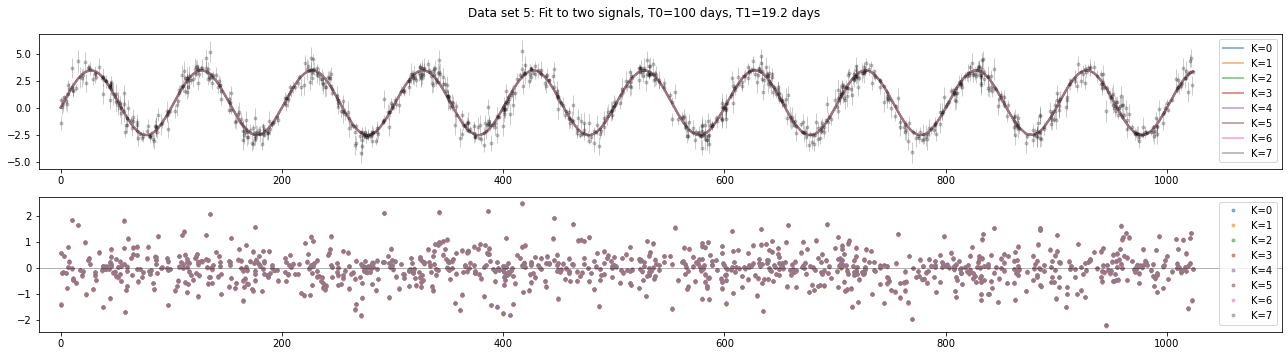

Data set 5 =====
AIC: 
 1 signal: [995.98836078 996.28663881 996.32750129 996.31472145 995.97809992
 996.20301008 996.37410436 996.78337647] 
 2 signals: [994.91129209 995.9118254  995.16696661 995.65970074 994.83380485
 995.16840387 995.27562711 995.68670544]
BIC: 
 1 signal: [1015.714248   1016.01252603 1016.05338851 1016.04060867 1015.70398714
 1015.92889731 1016.09999159 1016.50926369] 
 2 signals: [1029.43159473 1030.43212804 1029.68726925 1030.18000338 1029.35410749
 1029.68870651 1029.79592975 1030.20700808]


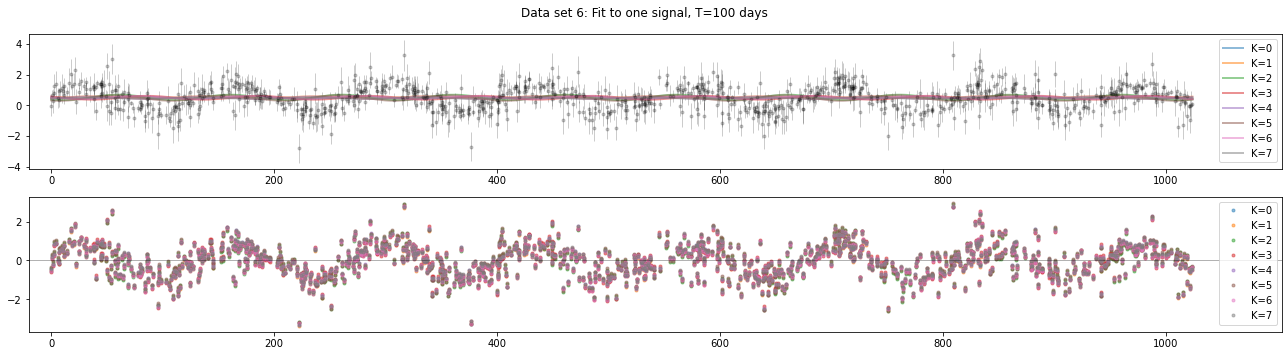

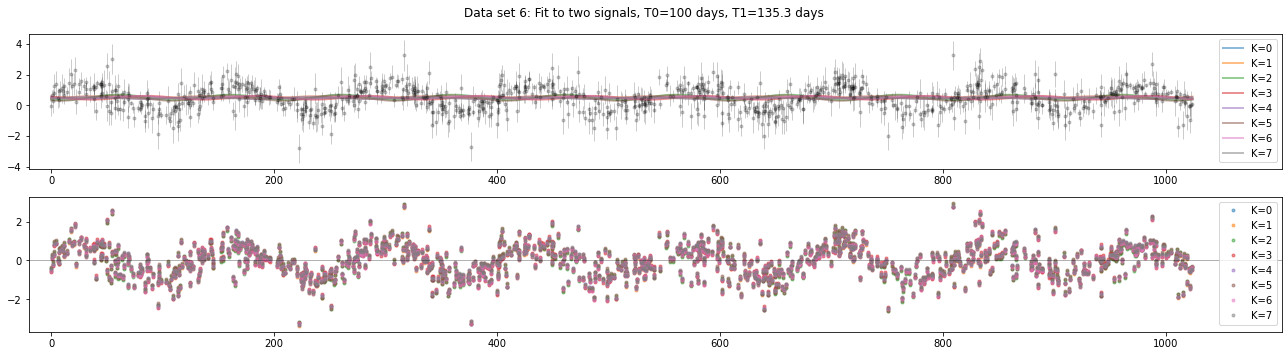

Data set 6 =====
AIC: 
 1 signal: [4354.64528992 4384.00619974 4409.03535705 4417.89174929 4385.13750928
 4419.43854555 4362.18241314 4373.37006033] 
 2 signals: [1023.38851478 1023.86703477 1023.50999962 1023.44855974 1024.83335923
 1023.70446843 1023.79486216 1023.73153006]
BIC: 
 1 signal: [4374.37117714 4403.73208696 4428.76124428 4437.61763651 4404.8633965
 4439.16443277 4381.90830036 4393.09594756] 
 2 signals: [1057.90881742 1058.38733741 1058.03030226 1057.96886238 1059.35366187
 1058.22477107 1058.3151648  1058.2518327 ]


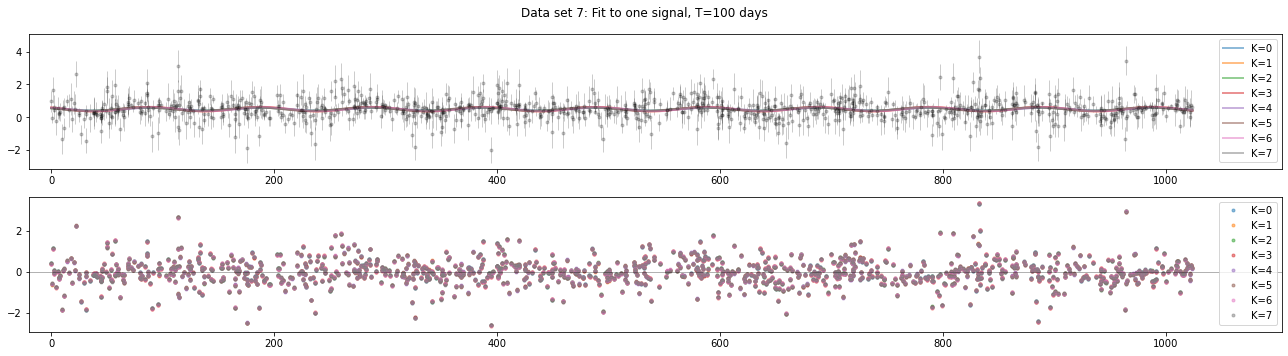

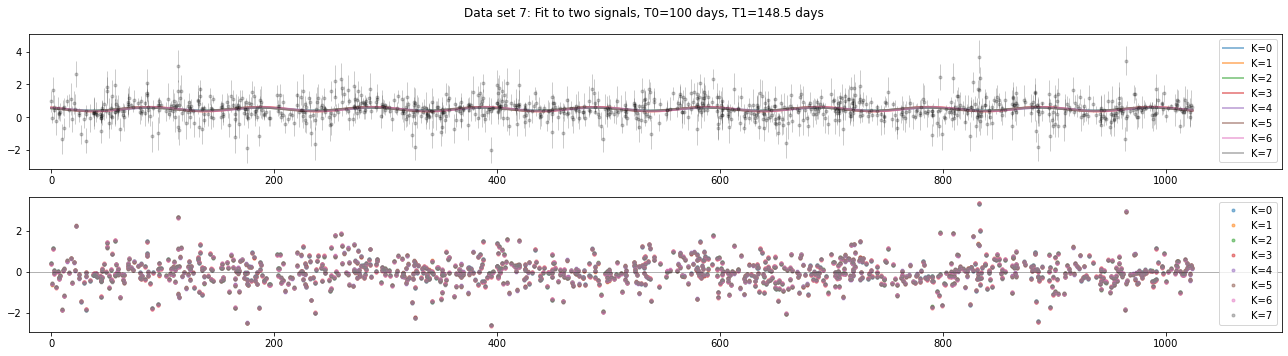

Data set 7 =====
AIC: 
 1 signal: [1293.65216855 1297.11376393 1295.65701627 1294.47907385 1299.22804725
 1297.08784678 1296.82075806 1296.17336466] 
 2 signals: [1085.71178396 1084.61324055 1085.70175095 1084.5831086  1085.61434612
 1084.85553285 1085.18134958 1084.87455933]
BIC: 
 1 signal: [1313.37805577 1316.83965115 1315.38290349 1314.20496107 1318.95393447
 1316.813734   1316.54664528 1315.89925189] 
 2 signals: [1120.2320866  1119.13354319 1120.22205359 1119.10341124 1120.13464876
 1119.37583549 1119.70165222 1119.39486197]


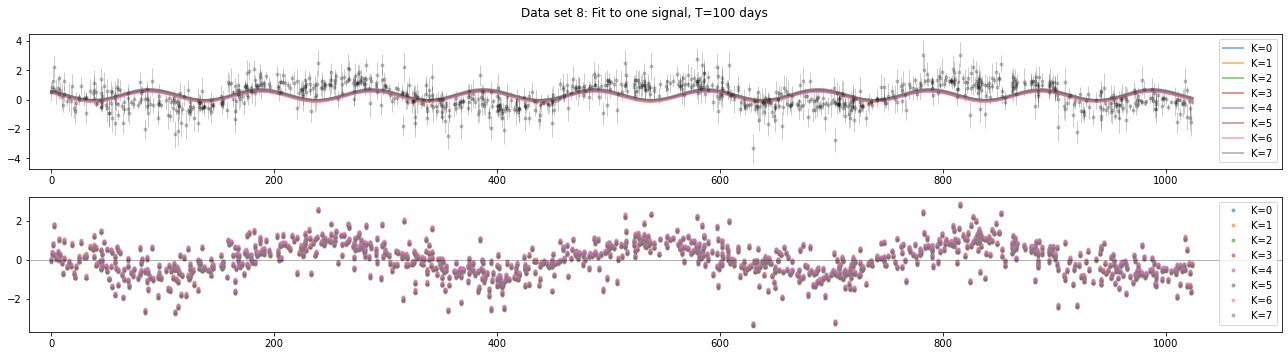

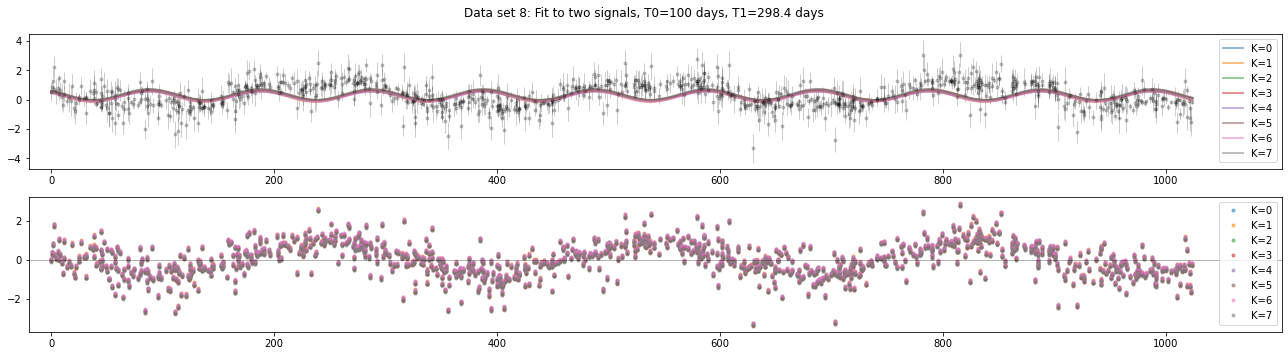

Data set 8 =====
AIC: 
 1 signal: [4399.13490789 4422.59056613 4398.60006273 4394.63236821 4414.07411469
 4438.88660172 4444.42769978 4439.32832709] 
 2 signals: [1086.80707416 1088.68968587 1089.96655261 1088.85421549 1088.14765309
 1087.202443   1087.04973202 1090.44367763]
BIC: 
 1 signal: [4418.86079511 4442.31645335 4418.32594995 4414.35825543 4433.80000191
 4458.61248895 4464.153587   4459.05421432] 
 2 signals: [1121.3273768  1123.20998851 1124.48685525 1123.37451813 1122.66795573
 1121.72274564 1121.57003465 1124.96398027]


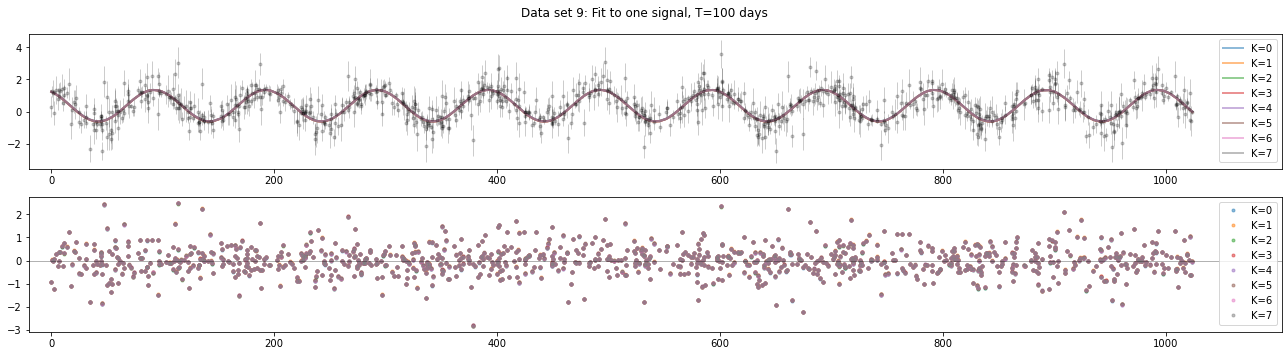

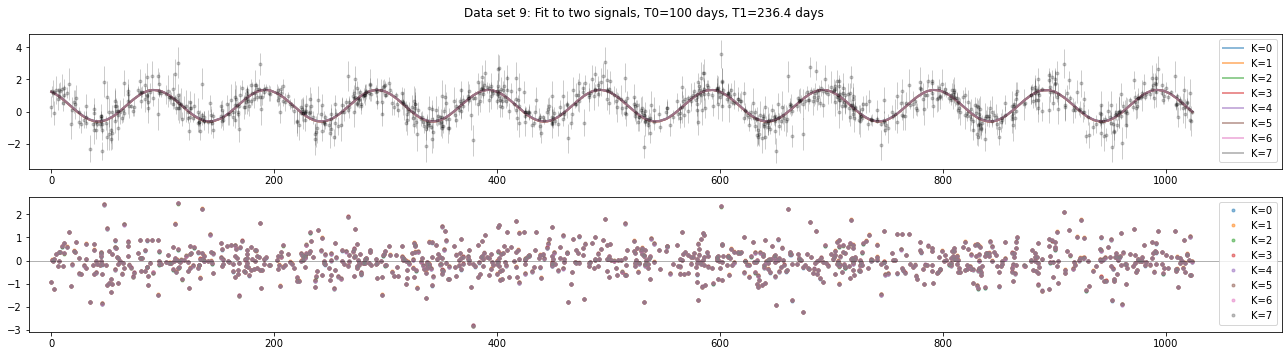

Data set 9 =====
AIC: 
 1 signal: [1127.32549911 1127.39907152 1126.91710644 1126.72524865 1126.54914076
 1126.76803522 1126.667849   1126.64515634] 
 2 signals: [1119.9889381  1119.45247935 1119.1467663  1119.46002174 1120.19768453
 1119.37608826 1119.13620329 1119.17403271]
BIC: 
 1 signal: [1147.05138633 1147.12495875 1146.64299366 1146.45113587 1146.27502799
 1146.49392245 1146.39373623 1146.37104356] 
 2 signals: [1154.50924073 1153.97278199 1153.66706894 1153.98032437 1154.71798717
 1153.8963909  1153.65650593 1153.69433535]


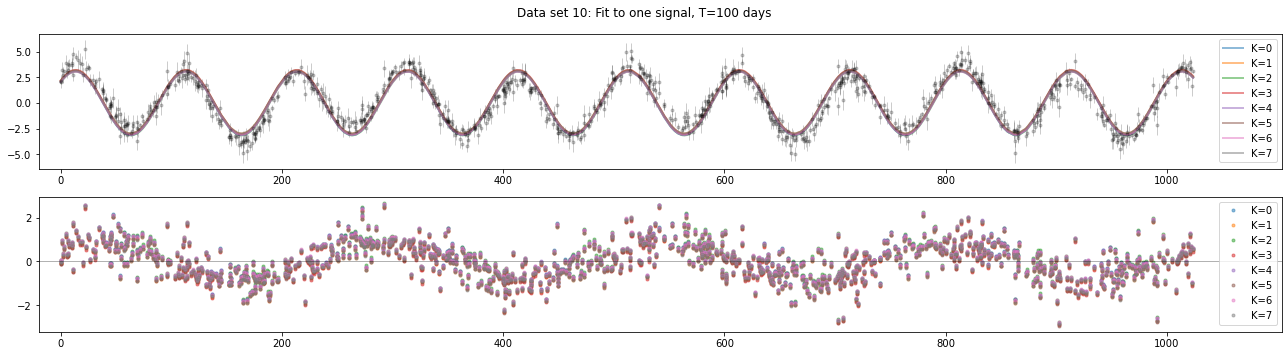

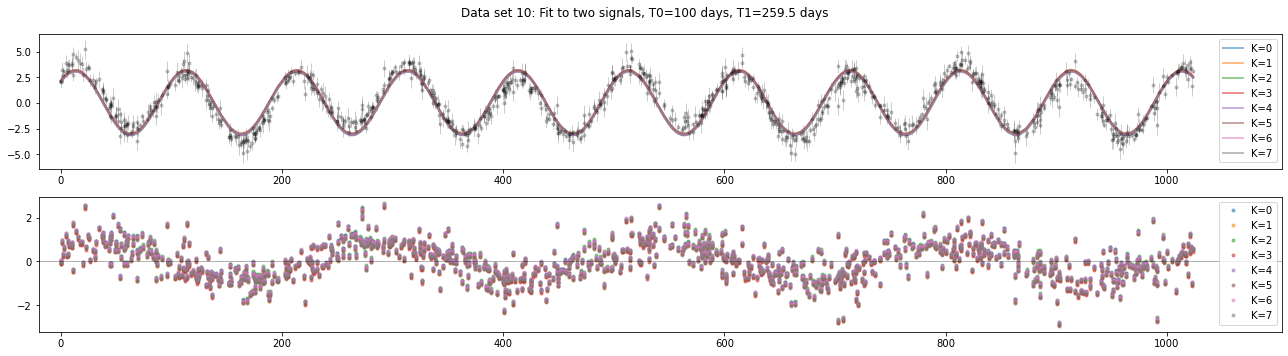

Data set 10 =====
AIC: 
 1 signal: [4221.20452721 4236.69742851 4275.50750901 4250.71045679 4234.70917708
 4252.96538926 4230.23379805 4230.64344167] 
 2 signals: [976.98691279 980.16733424 979.84259077 976.86115913 977.26126389
 977.14664958 978.36030454 980.55974816]
BIC: 
 1 signal: [4240.93041443 4256.42331573 4295.23339624 4270.43634401 4254.4350643
 4272.69127649 4249.95968527 4250.36932889] 
 2 signals: [1011.50721543 1014.68763688 1014.36289341 1011.38146177 1011.78156653
 1011.66695222 1012.88060718 1015.0800508 ]


In [103]:
for i, signal in enumerate(signals):
    kfold_crossval(time, signal, sigmas, nset=i)

### Bonus Problem

Same as problem #3 but with the fully marginalized likelihood (Bayesian evidence).